# Stock Price Preiction using LSTMs
***

In [2]:
# Importing all the dependencies
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime

from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers.legacy import Adam
from tensorflow.keras import layers

### Exploratory Data Analysis and Data Cleaning

In [3]:
data = pd.read_csv('./AAPL.csv')  # Downloaded data from Yahoo Finance
data.head(5)

,Date,Open,High,Low,Close,Adj Close,Volume
0,1980-12-12,0.128348,0.128906,0.128348,0.128348,0.099319,469033600
1,1980-12-15,0.122210,0.122210,0.121652,0.121652,0.094137,175884800
2,1980-12-16,0.113281,0.113281,0.112723,0.112723,0.087228,105728000
3,1980-12-17,0.115513,0.116071,0.115513,0.115513,0.089387,86441600
4,1980-12-18,0.118862,0.119420,0.118862,0.118862,0.091978,73449600


In [4]:
data = data[['Date', 'Close']]  # Gathering just the Date and the Close for training the model
data['Date']

0        1980-12-12
1        1980-12-15
2        1980-12-16
3        1980-12-17
4        1980-12-18
            ...    
10857    2024-01-08
10858    2024-01-09
10859    2024-01-10
10860    2024-01-11
10861    2024-01-12
Name: Date, Length: 10862, dtype: object

Since the Date column is an object datatype, we are converting it into a Datetime Object

In [5]:
def str_to_datetime(s): # Function to convert it into a Datetime object
    split = s.split('-')
    year, month, day = int(split[0]), int(split[1]), int(split[2])
    return datetime.datetime(year=year, month=month, day=day)

datetime_object = str_to_datetime('1986-03-19')
datetime_object

data['Date'] = data['Date'].apply(str_to_datetime)
data['Date']

0       1980-12-12
1       1980-12-15
2       1980-12-16
3       1980-12-17
4       1980-12-18
           ...    
10857   2024-01-08
10858   2024-01-09
10859   2024-01-10
10860   2024-01-11
10861   2024-01-12
Name: Date, Length: 10862, dtype: datetime64[ns]

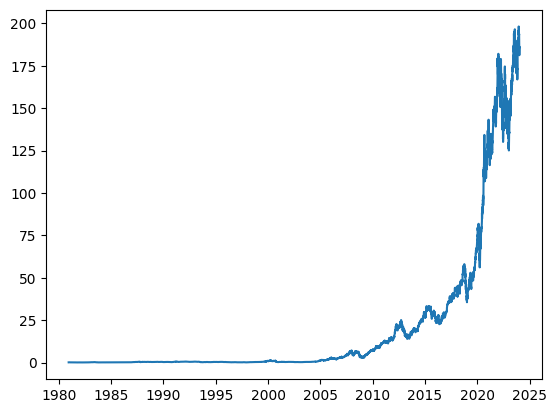

In [6]:
# Creating an index out of Dates
data.index = data.pop('Date')
plt.plot(data.index, data['Close'])  # Plotting a graph of the close values to get an idea of the trend

In [7]:
# Creating 3 different Feature values called Target-1, Target-2, and Target-3 so that we can train the model on a trend that leads to the Target
value = 3
for i in range(1,4):
    data[f'Target-{i}'] = data['Close'].shift(i)
data = data.dropna()
data = data.rename(columns={"Close":'Target'})
print(data)

                Target    Target-1    Target-2    Target-3
Date                                                      
1980-12-17    0.115513    0.112723    0.121652    0.128348
1980-12-18    0.118862    0.115513    0.112723    0.121652
1980-12-19    0.126116    0.118862    0.115513    0.112723
1980-12-22    0.132254    0.126116    0.118862    0.115513
1980-12-23    0.137835    0.132254    0.126116    0.118862
...                ...         ...         ...         ...
2024-01-08  185.559998  181.179993  181.910004  184.250000
2024-01-09  185.139999  185.559998  181.179993  181.910004
2024-01-10  186.190002  185.139999  185.559998  181.179993
2024-01-11  185.589996  186.190002  185.139999  185.559998
2024-01-12  185.919998  185.589996  186.190002  185.139999

[10859 rows x 4 columns]


From running the model once without splitting the data, I was able to figure out that the trend really starts to change after 2017. Until 2017, the stock trend was more or less the same. So, I chose the data after 2017 to reduce underfitting.

In [8]:
# Splitting data to reduce underfitting
split_date = pd.to_datetime("2017-01-01")
data2 = data.iloc[data.index>split_date]
data2

,Target,Target-1,Target-2,Target-3
Date,,,,
2017-01-03,29.037500,28.955000,29.182501,29.190001
2017-01-04,29.004999,29.037500,28.955000,29.182501
2017-01-05,29.152500,29.004999,29.037500,28.955000
2017-01-06,29.477501,29.152500,29.004999,29.037500
2017-01-09,29.747499,29.477501,29.152500,29.004999
...,...,...,...,...
2024-01-08,185.559998,181.179993,181.910004,184.250000
2024-01-09,185.139999,185.559998,181.179993,181.910004
2024-01-10,186.190002,185.139999,185.559998,181.179993


In [9]:
# Creating Features and Target variables to train the model

dates = data2.index.to_numpy()
features = data2.drop(['Target'], axis=1).to_numpy()
X = features.reshape((len(dates), features.shape[1],1))
Y = data2['Target'].to_numpy()
X.astype(np.float32)
Y.astype(np.float32)

dates.shape, X.shape, Y.shape  # Checking if all three consists of the same amount of rows

((1769,), (1769, 3, 1), (1769,))

In [10]:
# Splitting the data into train, test and validation variables
dates_train, dates_temp, X_train, X_temp, Y_train, Y_temp = train_test_split(dates, X, Y, test_size=0.2, shuffle=False)
dates_test, dates_val, X_test, X_val, Y_test, Y_val = train_test_split(dates_temp, X_temp, Y_temp, test_size=0.5, shuffle=False)

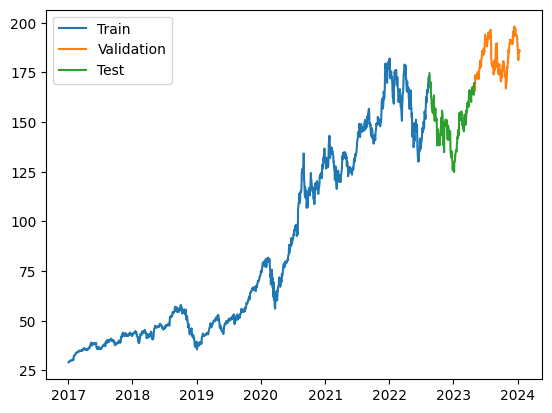

In [11]:
# Plotting to check the train, test and validation split
plt.plot(dates_train, Y_train)
plt.plot(dates_val, Y_val)
plt.plot(dates_test, Y_test)

plt.legend(['Train', 'Validation', 'Test'])

## Model Training
***

In [12]:
model = Sequential([layers.Input((3,1)),
                    layers.LSTM(64),
                    layers.Dense(32, activation='relu'),
                    layers.Dense(32, activation='relu'),
                    layers.Dense(1)])
model.compile(loss='mse', 
              optimizer=Adam(learning_rate=0.001), 
              metrics=['mean_absolute_error'])

model.fit(X_train, Y_train, validation_data=(X_val, Y_val), epochs=100)

2024-02-03 11:01:38.170366: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1
2024-02-03 11:01:38.170392: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 8.00 GB
2024-02-03 11:01:38.170401: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 2.67 GB
2024-02-03 11:01:38.170709: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-02-03 11:01:38.170963: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Epoch 1/100


2024-02-03 11:01:39.110247: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


45/45 [==============================] - 2s 21ms/step - loss: 8645.6221 - mean_absolute_error: 80.1625 - val_loss: 30328.9375 - val_mean_absolute_error: 173.9552
Epoch 2/100
45/45 [==============================] - 0s 11ms/step - loss: 5475.5112 - mean_absolute_error: 56.7642 - val_loss: 13517.6846 - val_mean_absolute_error: 115.9567
Epoch 3/100
45/45 [==============================] - 1s 11ms/step - loss: 2022.0825 - mean_absolute_error: 39.9920 - val_loss: 8357.0664 - val_mean_absolute_error: 91.0596
Epoch 4/100
45/45 [==============================] - 0s 11ms/step - loss: 468.6735 - mean_absolute_error: 12.3640 - val_loss: 1530.0853 - val_mean_absolute_error: 38.2997
Epoch 5/100
45/45 [==============================] - 1s 11ms/step - loss: 32.1628 - mean_absolute_error: 3.2297 - val_loss: 471.0227 - val_mean_absolute_error: 20.3755
Epoch 6/100
45/45 [==============================] - 0s 11ms/step - loss: 14.7663 - mean_absolute_error: 2.5028 - val_loss: 274.9410 - val_mean_absolute_

## Analyzing the Results
***
### Graphs

45/45 [==============================] - 0s 3ms/step


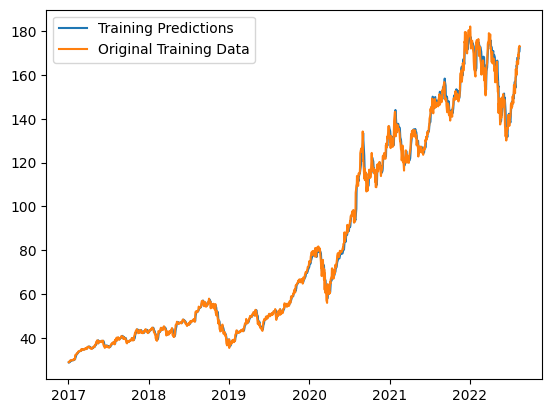

In [13]:
# Train data graph
train_predictions = model.predict(X_train).flatten()
plt.plot(dates_train, train_predictions)
plt.plot(dates_train, Y_train)
plt.legend(['Training Predictions', 'Original Training Data'])

6/6 [==============================] - 0s 5ms/step


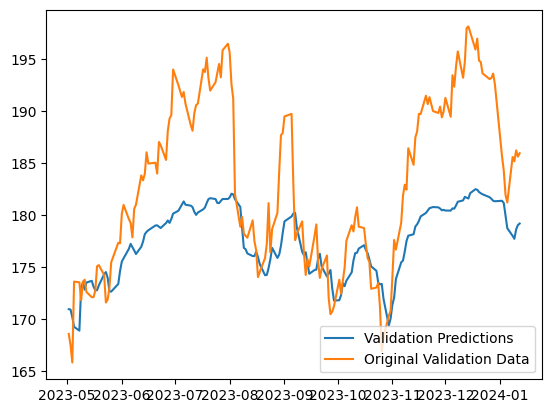

In [14]:
# Validation data graph
val_predictions = model.predict(X_val).flatten()
plt.plot(dates_val, val_predictions)
plt.plot(dates_val, Y_val)
plt.legend(['Validation Predictions', 'Original Validation Data'])

6/6 [==============================] - 0s 3ms/step


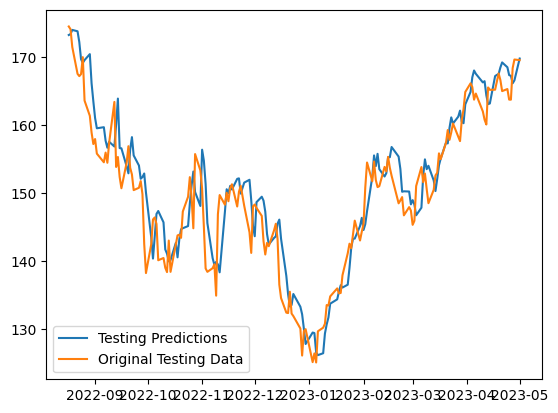

In [15]:
# Test data graph
test_predictions = model.predict(X_test).flatten()
plt.plot(dates_test, test_predictions)
plt.plot(dates_test, Y_test)
plt.legend(['Testing Predictions', 'Original Testing Data'])

### Loss Functions

In [16]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [17]:
rmse = np.sqrt(mean_squared_error(Y_test, test_predictions))
mape = mean_absolute_error(Y_test, test_predictions)
print(f"RMSE: {rmse}")
print(f"MAPE: {mape}")

RMSE: 4.1604643711672935
MAPE: 3.2698007811920684
